# Checking the effect of dead time in Fermi/GBM Data

Let's make a light curve from a CARMA model, and see what dead time does to the results:
We need to implement a CARMA model

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS and numpyro for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA

from jaxns.utils import resample
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoNormal

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import _skew_gaussian

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-11-05 22:44:11,689]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1699220651.689213       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-11-05 22:44:11,690]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-11-05 22:44:11,695]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

## Latent GP Model with CARMA + Numpyro

Let's generate some data:

INFO[2023-11-07 15:29:26,757]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-07 15:29:26,757]: Checking if light curve is sorted.
INFO[2023-11-07 15:29:26,758]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-220151163.0835632


<IPython.core.display.Javascript object>


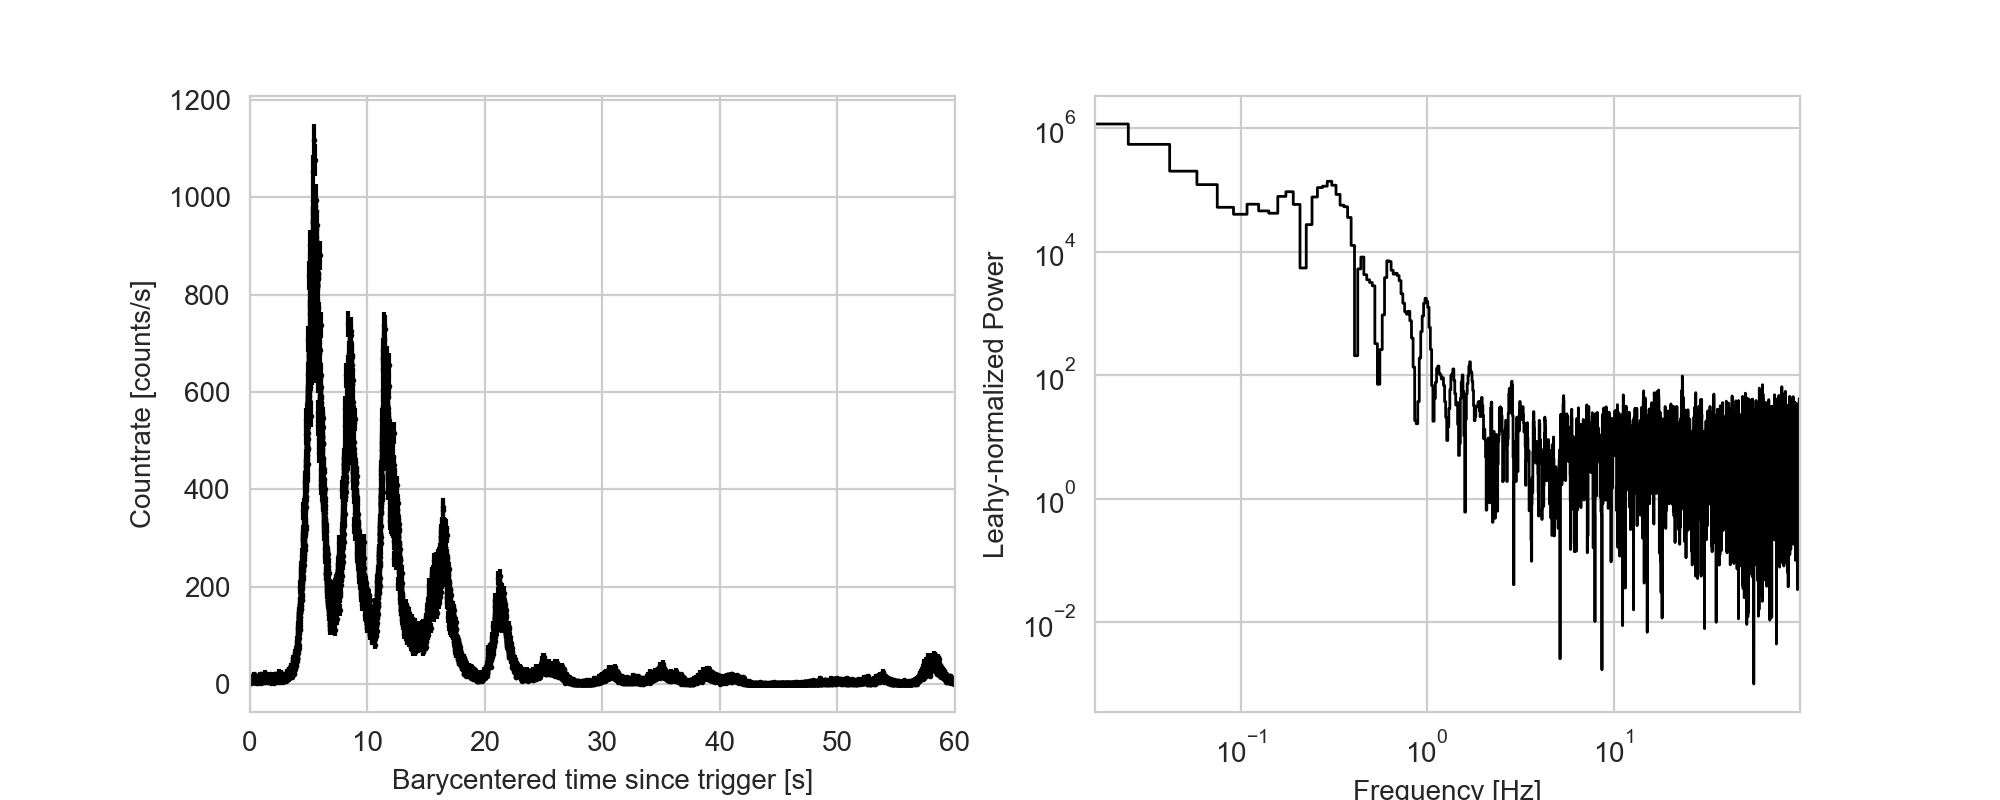

In [137]:
#alpha = [.8, 1.2, 1.7]
#beta = [1.5]
#sigma = 1e5

alpha = [1.1, 1.5]
beta = [1.7]
sigma = 4

skew_amp = 2.0
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 15.0


kernel_params_true = {"alpha": alpha,
                      "beta": beta,
                      "acarma": sigma}
mean_params_true = {"A": skew_amp, 
                    "t0": skew_t0, 
                    "sig1": skew_sig1, 
                    "sig2": skew_sig2}

time = np.linspace(0, 60, 10*int(60/0.05))

mean = _skew_gaussian(time, mean_params_true) + 0.7
#mean = np.ones_like(time)

kernel = CARMA.init(alpha=alpha, beta=beta)
gp = GaussianProcess(kernel, time, mean_value=mean, diag=0.01)

key = random.PRNGKey(100)
#print(gp.sample(key))
sample = np.exp(gp.sample(key) + mean)
#print(sample)
#sample = gp.sample(key)
sample = np.random.poisson(sample)

#err = np.random.normal(0.0, np.sqrt(np.abs(sample)))
#sample = sample + err

gp.condition(sample)
print(gp.log_probability(sample))
lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")
#ax1.set_ylim(0, 200)

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


#plot_kernel(kernel)

Let's apply dead time and compare the two:

In [138]:
def _nonpar_core(event_list, dead_time_end, mask):
    """Numba-compiled core of the non-paralyzable dead time calculation.

    Parameters
    ----------
    event_list : array of floats
        Event times of arrival
    dead_time_end : array of floats
        End of the dead time of each event
    mask : array of bools
        Final mask of good events. Initially, all entries must be ``True``

    Return
    ------
    mask : array of bools
        Final mask of good events
    """
    for i in range(1, len(event_list)):
        if event_list[i] < dead_time_end[i - 1]:
            dead_time_end[i] = dead_time_end[i - 1]
            mask[i] = False
    return mask

In [139]:
tte = []

for i, c in enumerate(lcsample.counts):
    tstart = lcsample.time[i]-0.5*lcsample.dt
    tend = lcsample.time[i] + 0.5*lcsample.dt
    tmp = np.random.uniform(tstart, tend, size=c)
    tte.extend(tmp)
    
tte = np.sort(tte)

dead_time = 2.6e-6

event_list_dbl = (tte - tte[0]).astype(np.double)
dead_time_end = event_list_dbl + np.double(dead_time)
mask = np.ones(event_list_dbl.size, dtype=bool)
mask = _nonpar_core(event_list_dbl, dead_time_end, mask)

tte_new = tte[mask]


In [143]:
len(tte_new)

799889

In [141]:
len(tte)

940333

In [142]:
print(len(tte_new)/len(tte))

0.8506443993776672


In [144]:
lcsample_deadtime = Lightcurve.make_lightcurve(tte_new, dt=0.05)
pssample_deadtime = Powerspectrum(lcsample_deadtime, norm="leahy")

INFO[2023-11-07 15:29:53,381]: make_lightcurve: tseg: 60.00413004324405
INFO[2023-11-07 15:29:53,382]: make_lightcurve: timebin:  1200


In [145]:
deadtime = 2.6e-6 
dt = 0.05

frac = deadtime/dt * lcsample_deadtime.counts


counts_corr = lcsample_deadtime.counts / (1. - frac) 

In [146]:
lcsample_corr = Lightcurve(lcsample_deadtime.time, counts_corr)
pssample_corr = Powerspectrum(lcsample_corr, norm="leahy")

INFO[2023-11-07 15:29:55,536]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-07 15:29:55,538]: Checking if light curve is sorted.
INFO[2023-11-07 15:29:55,540]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


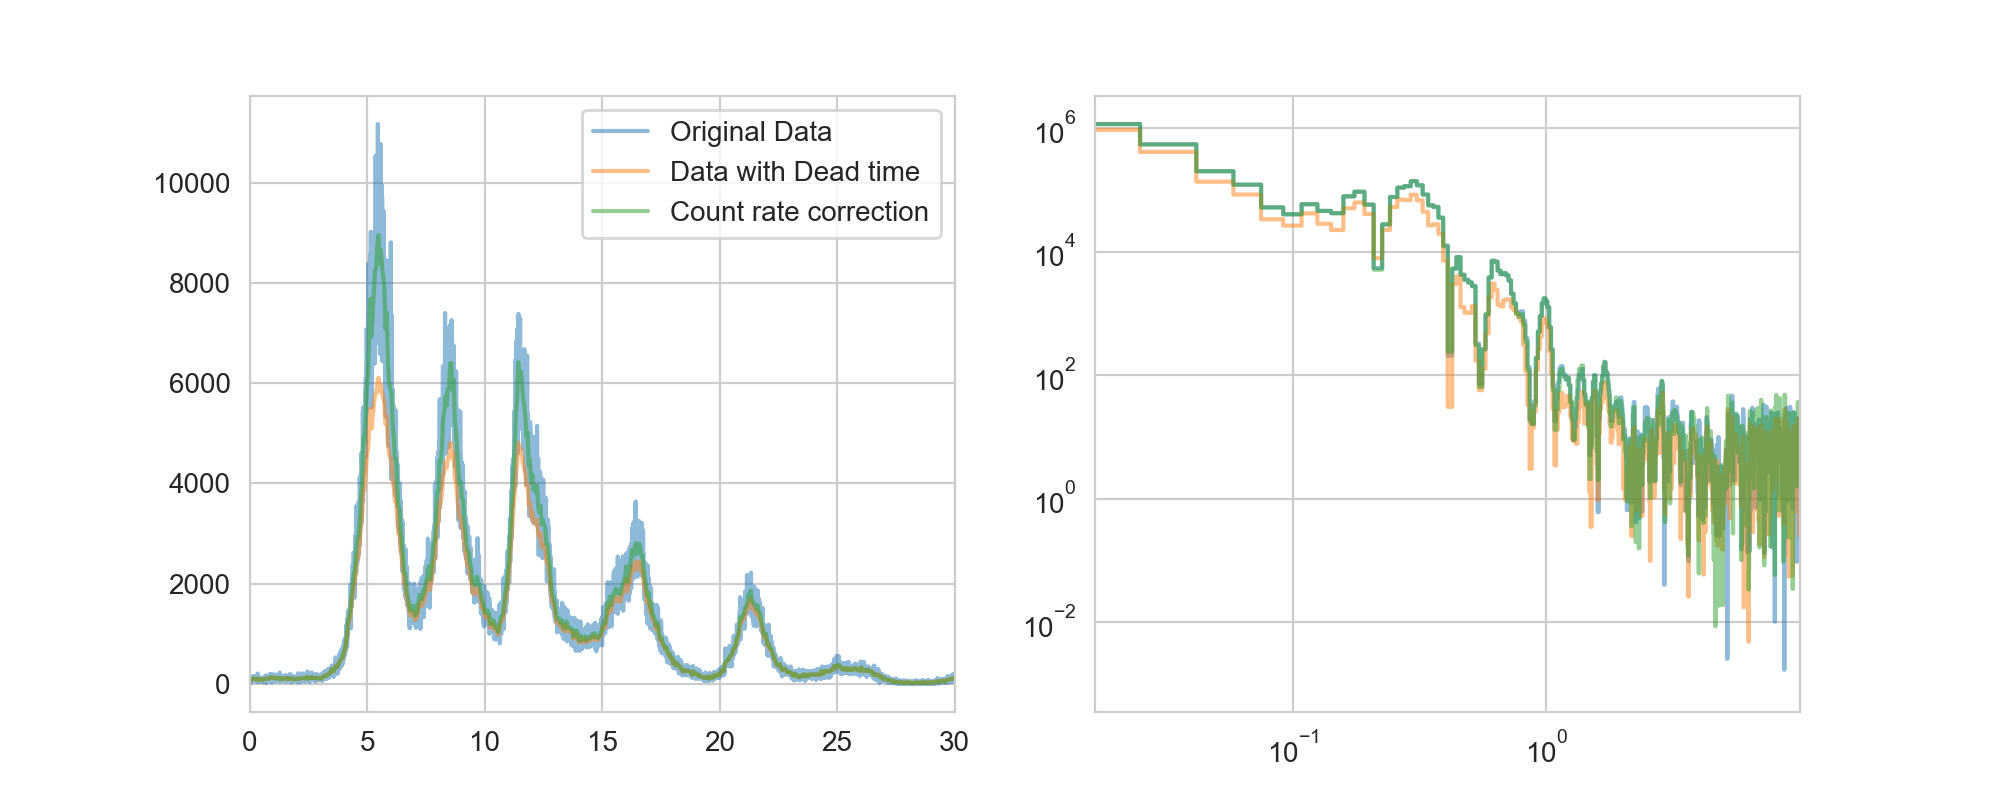

(0.016680567139282645, 9.991659716430304)

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lcsample.time, lcsample.counts*lcsample_corr.dt/lcsample.dt, alpha=0.5, label="Original Data")
ax1.plot(lcsample_deadtime.time, lcsample_deadtime.counts, alpha=0.5, label="Data with Dead time")
ax1.plot(lcsample_corr.time, lcsample_corr.counts, alpha=0.5, label="Count rate correction")
ax1.set_xlim(0, 30)

ax1.legend()

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", alpha=0.5)
ax2.loglog(pssample_deadtime.freq, pssample_deadtime.power, ds="steps-mid", alpha=0.5)
ax2.loglog(pssample_corr.freq, pssample_corr.power, ds="steps-mid", alpha=0.5)
ax2.set_xlim(pssample_corr.freq[0], pssample_corr.freq[-1])

## On the Real Fermi/GBM Data

In [67]:
datadir = "/Users/daniela/work/data/grb230307A/"
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"

data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
barytime = np.array(data["na_barytime"], dtype=float)
barytime = barytime
lc = Lightcurve.make_lightcurve(barytime, dt=0.05)
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-11-05 23:17:38,225]: make_lightcurve: tseg: 144.99889838695526
INFO[2023-11-05 23:17:38,226]: make_lightcurve: timebin:  2899


In [68]:

deadtime = 2.6e-6 
dt = 0.05

frac_obs = deadtime/dt * lc.counts


counts_obs_corr = lc.counts / (1. - frac_obs) 

lc_corr = Lightcurve(lc.time, counts_obs_corr)
ps_corr = Powerspectrum(lc_corr, norm="leahy")

INFO[2023-11-05 23:17:39,304]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-05 23:17:39,305]: Checking if light curve is sorted.
INFO[2023-11-05 23:17:39,307]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [69]:
np.sum(lc.counts)/np.sum(counts_obs_corr)

0.9440032003111702

<IPython.core.display.Javascript object>


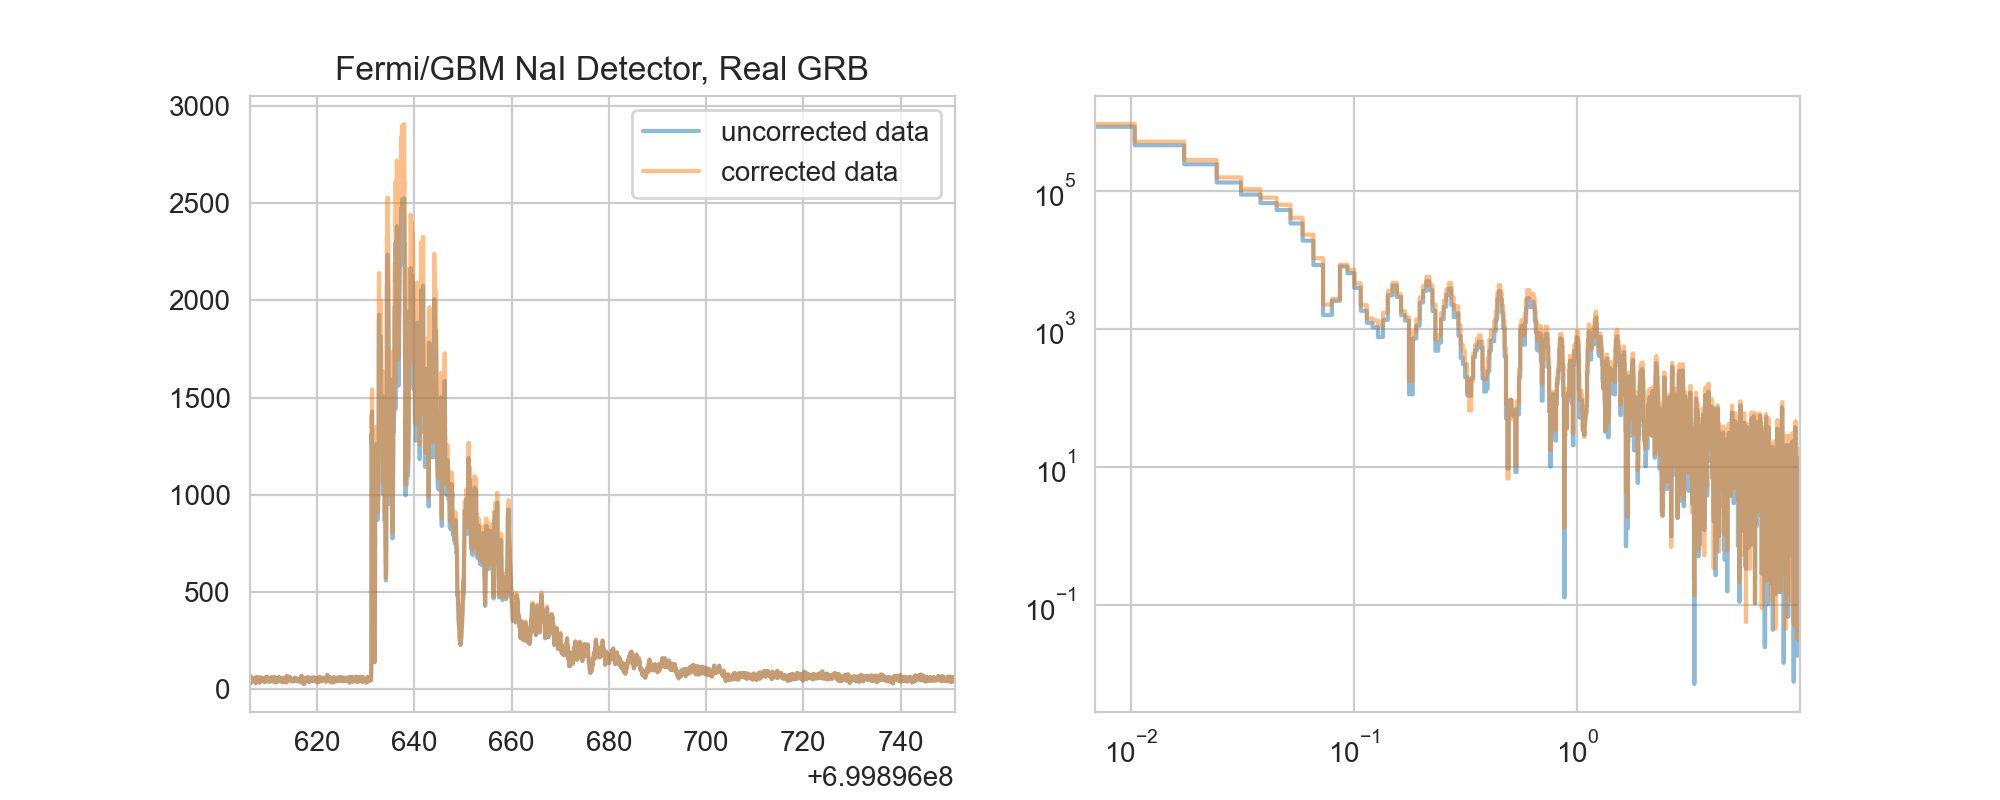

(0.006901311249137336, 9.993098688750862)

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, label="uncorrected data", alpha=0.5)
ax1.plot(lc.time, counts_obs_corr, label="corrected data", alpha=0.5)

ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_title("Fermi/GBM NaI Detector, Real GRB")
ax1.legend()

ax2.loglog(ps.freq, ps.power, ds="steps-mid", alpha=0.5)
ax2.loglog(ps_corr.freq, ps_corr.power, ds="steps-mid", alpha=0.5)

ax2.set_xlim(ps.freq[0], ps.freq[-1])

## Dead Time in Fermi, Simulated

In [121]:
def _nonpar_core(event_list, dead_time_end, mask):
    """Numba-compiled core of the non-paralyzable dead time calculation.

    Parameters
    ----------
    event_list : array of floats
        Event times of arrival
    dead_time_end : array of floats
        End of the dead time of each event
    mask : array of bools
        Final mask of good events. Initially, all entries must be ``True``

    Return
    ------
    mask : array of bools
        Final mask of good events
    """
    for i in range(1, len(event_list)):
        if event_list[i] < dead_time_end[i - 1]:
            dead_time_end[i] = dead_time_end[i - 1]
            mask[i] = False
    return mask


In [118]:
tstart = 0.0
tend = 50.0

ncounts = np.random.poisson(1e7)
tte = np.random.uniform(tstart, tend, ncounts)

tte = np.sort(tte)


In [120]:
dead_time = 2.6e-6

event_list_dbl = (tte - tte[0]).astype(np.double)
dead_time_end = event_list_dbl + np.double(dead_time)
mask = np.ones(event_list_dbl.size, dtype=bool)
mask = _nonpar_core(event_list_dbl, dead_time_end, mask)

tte_new = tte[mask]


In [122]:
len(tte_new)/len(tte)

0.6579084940519083

In [127]:
lc = Lightcurve.make_lightcurve(tte, dt=5e-8)
lc_dt = Lightcurve.make_lightcurve(tte_new, dt=5e-8)

INFO[2023-11-07 15:21:24,062]: make_lightcurve: tseg: 49.999996001615905
INFO[2023-11-07 15:21:24,063]: make_lightcurve: timebin:  999999920
INFO[2023-11-07 15:21:41,727]: make_lightcurve: tseg: 49.999996001615905
INFO[2023-11-07 15:21:41,729]: make_lightcurve: timebin:  999999920


In [124]:
from stingray import AveragedPowerspectrum

In [128]:
ps = AveragedPowerspectrum(lc,segment_size=0.01, norm="leahy")
ps_dt = AveragedPowerspectrum(lc_dt,segment_size=0.01, norm="leahy")

4999it [00:48, 103.61it/s]
4999it [00:41, 119.51it/s]


<IPython.core.display.Javascript object>


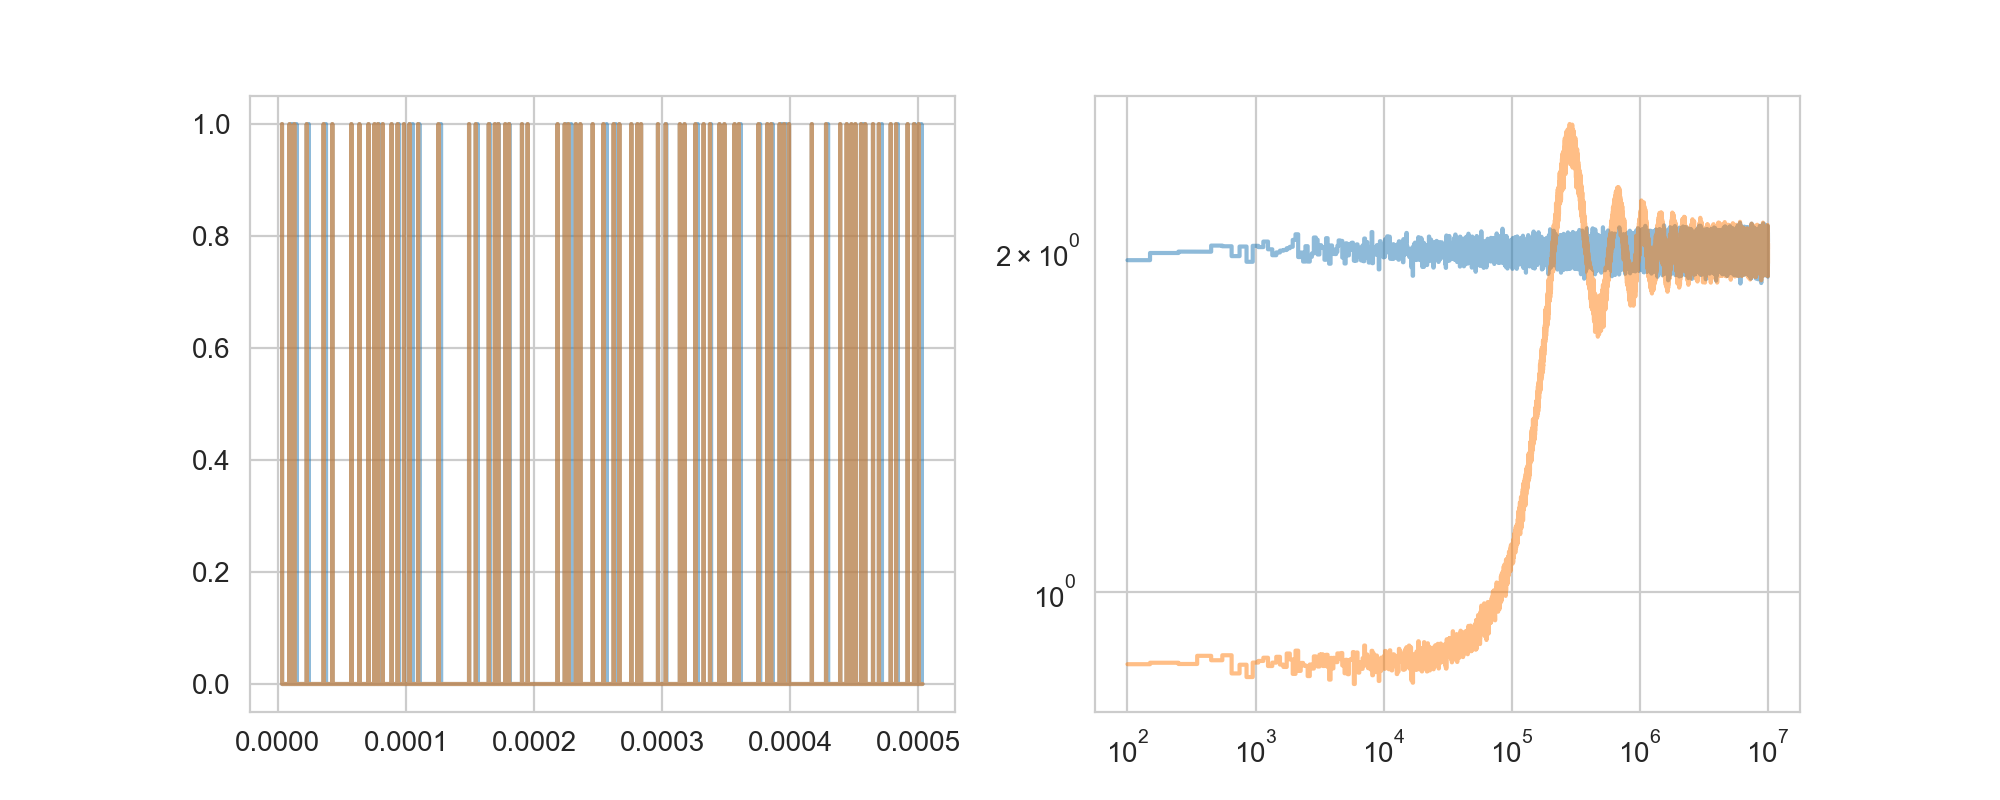

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(lc.time[:10000], lc.counts[:10000], alpha=0.5)
ax1.plot(lc_dt.time[:10000], lc_dt.counts[:10000], alpha=0.5)

ax2.loglog(ps.freq, ps.power, ds="steps-mid", alpha=0.5)
ax2.loglog(ps_dt.freq, ps_dt.power, ds="steps-mid", alpha=0.5)

In [132]:
lc_coarse = Lightcurve.make_lightcurve(tte_new, dt=0.0001)

INFO[2023-11-07 15:25:15,445]: make_lightcurve: tseg: 49.999996001615905
INFO[2023-11-07 15:25:15,446]: make_lightcurve: timebin:  499999


In [133]:
deadtime = 2.6e-6 
dt = lc_coarse.dt

frac_obs = deadtime/dt * lc_coarse.counts

counts_obs_corr = lc_coarse.counts / (1. - frac_obs) 

lc_corr = Lightcurve(lc_coarse.time, counts_obs_corr)

INFO[2023-11-07 15:25:19,399]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-07 15:25:19,401]: Checking if light curve is sorted.
INFO[2023-11-07 15:25:19,404]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [134]:
ps_corr = AveragedPowerspectrum(lc_corr, segment_size=0.1, norm="leahy")

499it [00:00, 20450.02it/s]


<IPython.core.display.Javascript object>


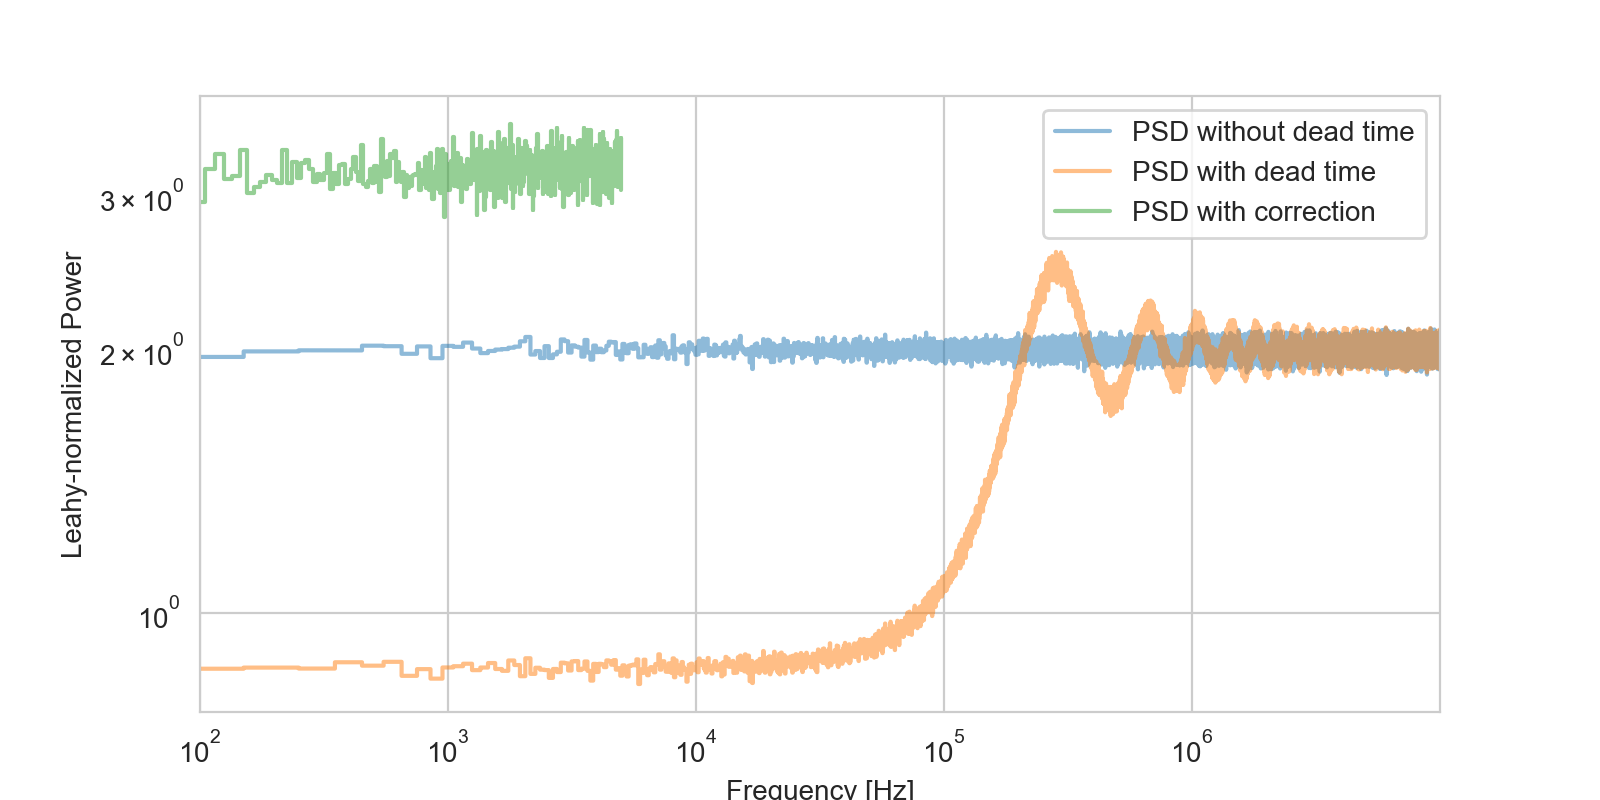

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(ps.freq, ps.power, ds="steps-mid", alpha=0.5, label="PSD without dead time")
ax.loglog(ps_dt.freq, ps_dt.power, ds="steps-mid", alpha=0.5, label="PSD with dead time")
ax.loglog(ps_corr.freq, ps_corr.power, ds="steps-mid", alpha=0.5, label="PSD with correction")

ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Leahy-normalized Power")

ax.legend()